In [16]:
import re
import collections
import time
from typing import List, Dict, Tuple, Set, Optional, Any
import heapq
import pickle
import os
import math

class ContextSensitiveSpellingCorrector:
    def __init__(self, unigram_path: Optional[str] = None,
                 bigram_path: Optional[str] = None,
                 ngram_path: Optional[str] = None,
                 vocabulary_path: Optional[str] = None,
                 max_edit_distance: int = 2,
                 use_keyboard_distances: bool = True,
                 beam_width: int = 5,
                 cache_dir: str = 'cache'):
        """
        Initialize the spelling corrector.

        Args:
            unigram_path: Path to unigram frequency file
            bigram_path: Path to bigram frequency file
            ngram_path: Path to n-gram frequency file
            vocabulary_path: Path to vocabulary file
            max_edit_distance: Maximum edit distance for correction candidates
            use_keyboard_distances: Whether to use keyboard distances for edit costs
            beam_width: Maximum number of candidates to consider at each step
            cache_dir: Directory to store cached language models
        """
        self.max_edit_distance = max_edit_distance
        self.use_keyboard_distances = use_keyboard_distances
        self.beam_width = beam_width
        self.cache_dir = cache_dir

        # Create cache directory if it doesn't exist
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)

        # Load or build language models
        self.unigram_counts = self._load_or_build_unigrams(unigram_path)
        self.bigram_counts = self._load_or_build_bigrams(bigram_path)
        self.ngram_counts = self._load_or_build_ngrams(ngram_path)

        # Total word count for probability calculation
        self.total_words = sum(self.unigram_counts.values())

        # Build vocabulary from unigram counts
        self.vocabulary = set(self.unigram_counts.keys())

        # Add additional vocabulary if provided
        if vocabulary_path:
            self._add_vocabulary(vocabulary_path)

        # Build keyboard distance map if enabled
        if self.use_keyboard_distances:
            self.keyboard_distance = self._build_keyboard_distance()

    def _load_or_build_unigrams(self, path: Optional[str]) -> Dict[str, int]:
        """Load unigram frequencies from file or build from scratch."""
        cache_path = os.path.join(self.cache_dir, 'unigram_counts.pkl')

        # Try to load from cache
        if os.path.exists(cache_path):
            print(f"Loading unigram counts from cache: {cache_path}")
            with open(cache_path, 'rb') as f:
                return pickle.load(f)

        # If path is provided, build from file
        if path:
            print(f"Building unigram counts from: {path}")
            counts = collections.defaultdict(int)

            with open(path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) >= 2:
                        try:
                            count = int(parts[0])
                            word = parts[1].lower()
                            counts[word] += count
                        except (ValueError, IndexError):
                            # Skip lines with parsing issues
                            continue

            # Cache the results
            with open(cache_path, 'wb') as f:
                pickle.dump(dict(counts), f)

            return dict(counts)

        # Download Norvig's dataset if not available
        norvig_txt = os.path.join(self.cache_dir, 'big.txt')
        if not os.path.exists(norvig_txt):
            import urllib.request
            print("Downloading Norvig's dataset...")
            urllib.request.urlretrieve('https://norvig.com/big.txt', norvig_txt)

        # Build vocabulary from Norvig's dataset
        with open(norvig_txt, 'r', encoding='utf-8', errors='ignore') as f:
            words = re.findall(r'\w+', f.read().lower())
            counts = collections.Counter(words)

        # Cache the results
        with open(cache_path, 'wb') as f:
            pickle.dump(dict(counts), f)

        return dict(counts)

    def _load_or_build_bigrams(self, path: Optional[str]) -> Dict[Tuple[str, str], int]:
        """Load bigram frequencies from file or build from scratch."""
        cache_path = os.path.join(self.cache_dir, 'bigram_counts.pkl')

        # Try to load from cache
        if os.path.exists(cache_path):
            print(f"Loading bigram counts from cache: {cache_path}")
            with open(cache_path, 'rb') as f:
                return pickle.load(f)

        # If path is provided, build from file
        if path:
            print(f"Building bigram counts from: {path}")
            counts = collections.defaultdict(int)

            with open(path, 'r', encoding='ISO-8859-1') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) >= 3:
                        try:
                            count = int(parts[0])
                            word1 = parts[1].lower()
                            word2 = parts[2].lower()
                            counts[(word1, word2)] += count
                        except (ValueError, IndexError):
                            # Skip lines with parsing issues
                            continue

            # Cache the results
            with open(cache_path, 'wb') as f:
                pickle.dump(dict(counts), f)

            return dict(counts)

        # If no path provided, use empty default
        print("No bigram path provided. Using empty bigram model.")
        return {}

    def _load_or_build_ngrams(self, path: Optional[str]) -> Dict[Tuple[str, ...], int]:
        """Load n-gram frequencies from file or build from scratch."""
        cache_path = os.path.join(self.cache_dir, 'ngram_counts.pkl')

        # Try to load from cache
        if os.path.exists(cache_path):
            print(f"Loading n-gram counts from cache: {cache_path}")
            with open(cache_path, 'rb') as f:
                return pickle.load(f)

        # If path is provided, build from file
        if path:
            print(f"Building n-gram counts from: {path}")
            counts = collections.defaultdict(int)

            with open(path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    if len(parts) >= 3:  # At least frequency and 2 words
                        try:
                            count = int(parts[0])
                            words = tuple(word.lower() for word in parts[1:])
                            counts[words] += count
                        except (ValueError, IndexError):
                            # Skip lines with parsing issues
                            continue

            # Cache the results
            with open(cache_path, 'wb') as f:
                pickle.dump(dict(counts), f)

            return dict(counts)

        # If no path provided, use empty default
        print("No n-gram path provided. Using empty n-gram model.")
        return {}

    def _add_vocabulary(self, path: str) -> None:
        """Add words from a vocabulary file to the existing vocabulary."""
        try:
            with open(path, 'r', encoding='utf-8') as f:
                for line in f:
                    word = line.strip().lower()
                    if word:
                        self.vocabulary.add(word)
                        # Add to unigram counts with minimal frequency if not already present
                        if word not in self.unigram_counts:
                            self.unigram_counts[word] = 1
        except Exception as e:
            print(f"Error loading vocabulary: {e}")

    def _build_keyboard_distance(self) -> Dict[Tuple[str, str], float]:
        """Build a map of keyboard distances between characters."""
        # QWERTY keyboard layout
        keyboard = [
            "qwertyuiop",
            "asdfghjkl",
            "zxcvbnm"
        ]

        # Build map of character positions
        positions = {}
        for row_idx, row in enumerate(keyboard):
            for col_idx, char in enumerate(row):
                positions[char] = (row_idx, col_idx)

        # Calculate Euclidean distances
        distances = {}
        for c1 in positions:
            for c2 in positions:
                if c1 != c2:
                    r1, c1_pos = positions[c1]
                    r2, c2_pos = positions[c2]
                    # Euclidean distance
                    distance = math.sqrt((r1 - r2) ** 2 + (c1_pos - c2_pos) ** 2)
                    # Normalize to [0, 1] range
                    normalized_distance = distance / 5.0  # 5 is approximately the maximum distance
                    distances[(c1, c2)] = normalized_distance

        return distances

    def correct_text(self, text: str) -> str:
        """Correct all misspelled words in a text."""
        words = re.findall(r'\b\w+\b|\W+', text)
        corrected_words = []

        for i, word in enumerate(words):
            # Skip non-word tokens
            if not re.match(r'^\w+$', word):
                corrected_words.append(word)
                continue

            # Get context (previous words)
            prev_words = []
            j = i - 1
            while j >= 0 and len(prev_words) < 2:
                if re.match(r'^\w+$', words[j]):
                    prev_words.insert(0, words[j].lower())
                j -= 1

            # Get context (next words)
            next_words = []
            j = i + 1
            while j < len(words) and len(next_words) < 2:
                if re.match(r'^\w+$', words[j]):
                    next_words.append(words[j].lower())
                j += 1

            # Correct word based on context
            corrected_word = self.correct_word(word.lower(), prev_words, next_words)

            # Preserve original case
            if word.isupper():
                corrected_word = corrected_word.upper()
            elif word[0].isupper():
                corrected_word = corrected_word.capitalize()

            corrected_words.append(corrected_word)

        return ''.join(corrected_words)

    def correct_word(self, word: str, prev_words: List[str], next_words: List[str]) -> str:
        """Correct a single word based on its context."""
        # If the word is already in our vocabulary or very short, return it
        if word in self.vocabulary or len(word) <= 1:
            return word

        # Generate candidate corrections
        candidates = self._get_candidates(word)

        # If no candidates found, return the original word
        if not candidates:
            return word

        # Score candidates based on frequency and context
        scored_candidates = []
        for candidate in candidates:
            # Base score is the unigram probability
            unigram_prob = self._unigram_probability(candidate)

            # Calculate context-based score
            context_score = self._context_score(candidate, prev_words, next_words)

            # Combine scores
            final_score = unigram_prob * (context_score ** 2)  # Square context score to give it more weight

            scored_candidates.append((candidate, final_score))

        # Sort by score and get the best candidate
        scored_candidates.sort(key=lambda x: x[1], reverse=True)

        # Return the best candidate
        return scored_candidates[0][0]

    def _get_candidates(self, word: str) -> List[str]:
        """Generate candidate corrections for a misspelled word."""
        # Check edit distance 0 (the word itself)
        if word in self.vocabulary:
            return [word]

        # Generate candidates with edit distance 1
        candidates1 = self._get_edit_distance_1(word)
        known_candidates1 = [c for c in candidates1 if c in self.vocabulary]

        # If we have candidates with edit distance 1, return them
        if known_candidates1:
            return known_candidates1

        # If max_edit_distance >= 2, generate candidates with edit distance 2
        if self.max_edit_distance >= 2:
            candidates2 = set()
            for c1 in candidates1:
                candidates2.update(self._get_edit_distance_1(c1))
            known_candidates2 = [c for c in candidates2 if c in self.vocabulary]

            # If we have candidates with edit distance 2, return them
            if known_candidates2:
                return known_candidates2

        # If no candidates found, return the original word
        return [word]

    def _get_edit_distance_1(self, word: str) -> Set[str]:
        """Generate all strings with edit distance 1 from the given word."""
        letters = 'abcdefghijklmnopqrstuvwxyz'
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]

        # Deletions
        deletes = [L + R[1:] for L, R in splits if R]

        # Transpositions (Damerau–Levenshtein distance)
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]

        # Replacements
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]

        # Insertions
        inserts = [L + c + R for L, R in splits for c in letters]

        return set(deletes + transposes + replaces + inserts)

    def _unigram_probability(self, word: str) -> float:
        """Calculate unigram probability of a word."""
        # Laplace smoothing
        return (self.unigram_counts.get(word, 0) + 1) / (self.total_words + len(self.vocabulary))

    def _context_score(self, word: str, prev_words: List[str], next_words: List[str]) -> float:
        """Calculate context-based score for a candidate word."""
        score = 1.0

        # Check bigrams with previous words
        for prev_word in prev_words:
            bigram = (prev_word, word)
            if bigram in self.bigram_counts:
                # Calculate conditional probability P(word | prev_word)
                prev_count = self.unigram_counts.get(prev_word, 0)
                if prev_count > 0:
                    bigram_prob = self.bigram_counts[bigram] / prev_count
                    score *= (1 + bigram_prob * 10)  # Scale up the impact

        # Check bigrams with next words
        for next_word in next_words:
            bigram = (word, next_word)
            if bigram in self.bigram_counts:
                # Calculate conditional probability P(next_word | word)
                word_count = self.unigram_counts.get(word, 0)
                if word_count > 0:
                    bigram_prob = self.bigram_counts[bigram] / word_count
                    score *= (1 + bigram_prob * 10)  # Scale up the impact

        # Check n-grams if we have them
        if self.ngram_counts:
            for n in range(3, 6):  # Check 3-grams to 5-grams
                # Check n-grams with the target word in different positions
                for i in range(n):
                    # Construct context around position i
                    context = []
                    for j in range(n):
                        if j < i:
                            idx = i - j - 1
                            if idx < len(prev_words):
                                context.append(prev_words[-(idx + 1)])
                            else:
                                context.append("")
                        elif j > i:
                            idx = j - i - 1
                            if idx < len(next_words):
                                context.append(next_words[idx])
                            else:
                                context.append("")
                        else:
                            context.append(word)

                    # Remove empty slots
                    context = [w for w in context if w]

                    # If we have a valid n-gram, check it
                    if len(context) >= 2:
                        context_tuple = tuple(context)
                        if context_tuple in self.ngram_counts:
                            ngram_count = self.ngram_counts[context_tuple]
                            score *= (1 + ngram_count * 0.01)  # Small boost for n-gram match

        return score

    def evaluate(self, test_data: List[Tuple[str, str]]) -> Dict[str, float]:
        """
        Evaluate the corrector on test data.

        Args:
            test_data: List of (original, corrupted) text pairs

        Returns:
            Dictionary with evaluation metrics
        """
        start_time = time.time()
        correct_count = 0
        word_count = 0

        for original, corrupted in test_data:
            corrected = self.correct_text(corrupted)

            # Split into words for evaluation
            original_words = re.findall(r'\b\w+\b', original.lower())
            corrected_words = re.findall(r'\b\w+\b', corrected.lower())

            # Count correctly corrected words
            min_len = min(len(original_words), len(corrected_words))
            for i in range(min_len):
                if original_words[i] == corrected_words[i]:
                    correct_count += 1
                word_count += 1

        # Calculate accuracy
        accuracy = correct_count / word_count if word_count > 0 else 0

        # Calculate time per word
        total_time = time.time() - start_time
        time_per_word = total_time / word_count if word_count > 0 else 0

        return {
            'accuracy': accuracy,
            'total_time': total_time,
            'time_per_word': time_per_word,
            'word_count': word_count
        }


# Helper functions for evaluation
def generate_test_data(text: str, error_rate: float = 0.1,
                       delete_prob: float = 0.25,
                       insert_prob: float = 0.25,
                       replace_prob: float = 0.25,
                       transpose_prob: float = 0.25,
                       seed: Optional[int] = None) -> List[Tuple[str, str]]:
    """
    Generate test data by corrupting words in text.

    Args:
        text: Original text
        error_rate: Probability of corrupting a word
        delete_prob: Probability of deletion error
        insert_prob: Probability of insertion error
        replace_prob: Probability of replacement error
        transpose_prob: Probability of transposition error
        seed: Random seed

    Returns:
        List of (original, corrupted) text pairs
    """
    import random
    if seed is not None:
        random.seed(seed)

    letters = 'abcdefghijklmnopqrstuvwxyz'

    result = []
    lines = text.strip().split('\n')

    for line in lines:
        if not line.strip():
            continue

        words = re.findall(r'\b\w+\b|\W+', line)
        corrupted_words = []

        for word in words:
            # Skip non-word tokens
            if not re.match(r'^\w+$', word):
                corrupted_words.append(word)
                continue

            # Decide whether to corrupt this word
            if len(word) > 1 and random.random() < error_rate:
                error_type = random.random()

                if error_type < delete_prob:
                    # Delete a random character
                    pos = random.randint(0, len(word) - 1)
                    corrupted = word[:pos] + word[pos+1:]

                elif error_type < delete_prob + insert_prob:
                    # Insert a random character
                    pos = random.randint(0, len(word))
                    char = random.choice(letters)
                    corrupted = word[:pos] + char + word[pos:]

                elif error_type < delete_prob + insert_prob + replace_prob:
                    # Replace a random character
                    pos = random.randint(0, len(word) - 1)
                    char = random.choice(letters.replace(word[pos], ''))
                    corrupted = word[:pos] + char + word[pos+1:]

                else:
                    # Transpose two adjacent characters
                    if len(word) >= 2:
                        pos = random.randint(0, len(word) - 2)
                        corrupted = word[:pos] + word[pos+1] + word[pos] + word[pos+2:]
                    else:
                        # Fallback to replacement for single-character words
                        pos = 0
                        char = random.choice(letters.replace(word[pos], ''))
                        corrupted = char

                corrupted_words.append(corrupted)
            else:
                corrupted_words.append(word)

        original = line
        corrupted = ''.join(corrupted_words)

        result.append((original, corrupted))

    return result


def load_coca_bigrams(file_path: str) -> Dict[Tuple[str, str], int]:
    """
    Load bigrams from COCA format file.

    Args:
        file_path: Path to COCA bigram file

    Returns:
        Dictionary mapping bigram tuples to frequencies
    """
    bigrams = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                try:
                    freq = int(parts[0])
                    word1 = parts[1].lower()
                    word2 = parts[2].lower()
                    bigrams[(word1, word2)] = freq
                except (ValueError, IndexError):
                    continue

    return bigrams


def load_coca_ngrams(file_path: str) -> Dict[Tuple[str, ...], int]:
    """
    Load n-grams from COCA format file.

    Args:
        file_path: Path to COCA n-gram file

    Returns:
        Dictionary mapping n-gram tuples to frequencies
    """
    ngrams = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:  # At least frequency and 2 words
                try:
                    freq = int(parts[0])
                    words = tuple(word.lower() for word in parts[1:])
                    ngrams[words] = freq
                except (ValueError, IndexError):
                    continue

    return ngrams


# Example usage
def main():
    # Paths to COCA data files
    bigram_path = "bigrams.txt"
    fivegram_path = "fivegrams.txt"

    # Initialize corrector
    corrector = ContextSensitiveSpellingCorrector(
        bigram_path=bigram_path,
        ngram_path=fivegram_path,
        max_edit_distance=2,
        use_keyboard_distances=True,
        beam_width=5
    )

    # Example sentences to correct
    test_sentences = [
        "dking sport is good for health",
        "dking species are endangered",
        "people love dking coffees in the morning",
        "she is wprking on her project",
        "we shoold try the new restaurant",
        "the famoys scientist made a discovery",
        "I wnat to lerarn programming"
    ]

    # Correct each sentence
    for sentence in test_sentences:
        corrected = corrector.correct_text(sentence)
        print(f"Original: {sentence}")
        print(f"Corrected: {corrected}")
        print()

    # Generate test data from sample text
    sample_text = """
    Context-sensitive spelling correction is a crucial component of modern text processing systems.
    It allows for the accurate correction of spelling errors by considering the surrounding words.
    This approach significantly improves correction accuracy compared to traditional methods.
    Many natural language processing applications rely on context-sensitive spelling correction.
    Machine learning techniques have further enhanced the capabilities of spelling correction systems.
    """

    test_data = generate_test_data(sample_text, error_rate=0.2, seed=42)

    # Print test data
    print("Test Data:")
    for original, corrupted in test_data:
        print(f"Original: {original}")
        print(f"Corrupted: {corrupted}")
        print()

    # Evaluate corrector
    evaluation = corrector.evaluate(test_data)
    print("Evaluation:")
    for metric, value in evaluation.items():
        print(f"{metric}: {value}")


if __name__ == "__main__":
    main()

Loading unigram counts from cache: cache/unigram_counts.pkl
Building bigram counts from: bigrams.txt
Building n-gram counts from: fivegrams.txt
Original: dking sport is good for health
Corrected: doing sport is good for health

Original: dking species are endangered
Corrected: doing species are endangered

Original: people love dking coffees in the morning
Corrected: people love doing coffee in the morning

Original: she is wprking on her project
Corrected: she is working on her project

Original: we shoold try the new restaurant
Corrected: we should try the new restaurant

Original: the famoys scientist made a discovery
Corrected: the famous scientist made a discovery

Original: I wnat to lerarn programming
Corrected: I want to learn programming

Test Data:
Original: Context-sensitive spelling correction is a crucial component of modern text processing systems.
Corrupted: Context-senesitive spelling correction is a ccrucial component of moder text processing systems.

Original:     It

Generating test corpus...
Initializing correctors...
Loading unigram counts from cache: cache/unigram_counts.pkl
Loading bigram counts from cache: cache/bigram_counts.pkl
Loading n-gram counts from cache: cache/ngram_counts.pkl
Evaluating at different error rates...
Error rate: 0.05
Sample test case (error rate = 0.05):
Original: A researcher developed models thoroughly.
Corrupted: A researcher deveeloped models thoroughly.
Context-sensitive corrector accuracy: 0.8560
Norvig's corrector accuracy: 0.8560

Error rate: 0.1
Sample test case (error rate = 0.1):
Original: A researcher developed models thoroughly.
Corrupted: A researcher deveeloped models thoroughly.
Context-sensitive corrector accuracy: 0.8498
Norvig's corrector accuracy: 0.8477

Error rate: 0.2
Sample test case (error rate = 0.2):
Original: A researcher developed models thoroughly.
Corrupted: A researcher deveeloped models thoroughly.
Context-sensitive corrector accuracy: 0.8230
Norvig's corrector accuracy: 0.8251

Error ra

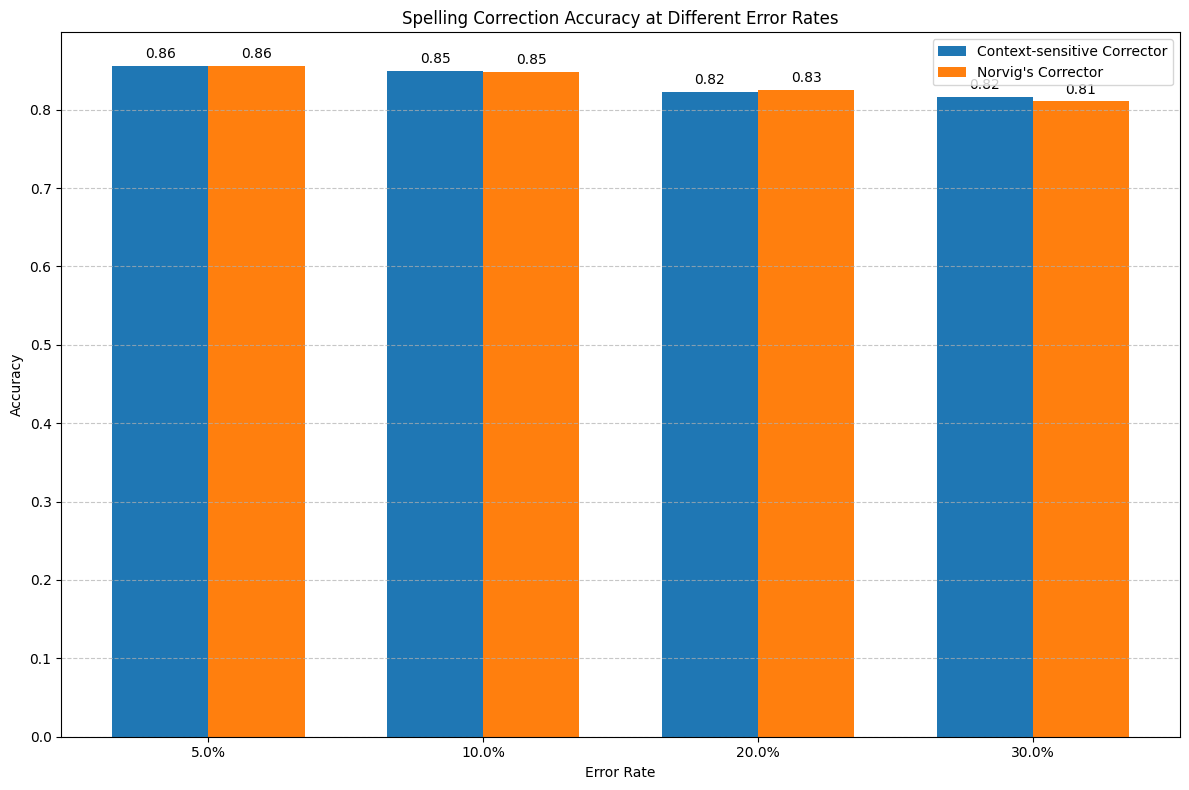

Testing specific examples to demonstrate context sensitivity:

Original: dking sport is good for health
Context-sensitive: doing sport is good for health
Norvig: king sport is good for health

Original: dking species are endangered
Context-sensitive: doing species are endangered
Norvig: king species are endangered

Original: people love dking coffees in the morning
Context-sensitive: people love doing coffee in the morning
Norvig: people love king coffee in the morning

Original: she is wprking on a new paper
Context-sensitive: she is working on a new paper
Norvig: she is working on a new paper

Original: the famoys scientist made a discovery
Context-sensitive: the famous scientist made a discovery
Norvig: the famous scientist made a discovery

Original: I wnat to lerarn programming
Context-sensitive: I want to learn programming
Norvig: I what to learn programming

Analyzing specific error types...
Error type: deletion
Context-sensitive corrector accuracy: 0.8189
Norvig's corrector acc

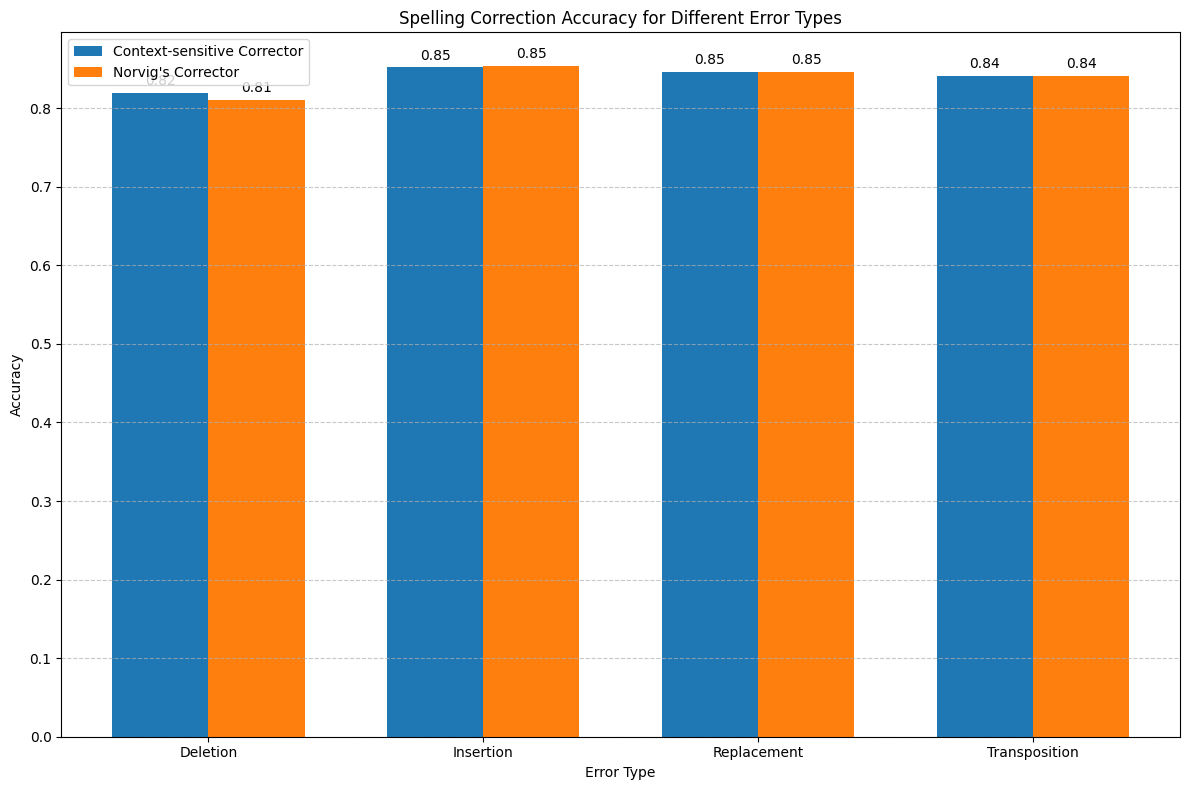

In [18]:
import re
import collections
import string
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Tuple, Set, Optional, Any


class NorvigSpellingCorrector:
    """Implementation of Peter Norvig's spelling corrector for comparison."""

    def __init__(self, text_path: str = None):
        """Initialize the Norvig spelling corrector."""
        self.words = self._load_words(text_path)
        self.total = sum(self.words.values())

    def _load_words(self, text_path: str = None) -> Dict[str, int]:
        """Load word frequencies from a text file."""
        if text_path:
            with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
                words = re.findall(r'\w+', f.read().lower())
                return collections.Counter(words)
        else:
            # Download Norvig's dataset if not available
            import os
            import urllib.request

            norvig_txt = 'big.txt'
            if not os.path.exists(norvig_txt):
                print("Downloading Norvig's dataset...")
                urllib.request.urlretrieve('https://norvig.com/big.txt', norvig_txt)

            with open(norvig_txt, 'r', encoding='utf-8', errors='ignore') as f:
                words = re.findall(r'\w+', f.read().lower())
                return collections.Counter(words)

    def probability(self, word: str) -> float:
        """Calculate the probability of a word."""
        return self.words.get(word, 0) / self.total

    def correction(self, word: str) -> str:
        """Return the most probable correction for a word."""
        # If the word is already in our vocabulary, return it
        if word in self.words:
            return word

        # Generate candidate corrections and select the most probable one
        candidates = self.candidates(word)
        if candidates:
            return max(candidates, key=self.probability)
        else:
            return word

    def candidates(self, word: str) -> Set[str]:
        """Generate candidate corrections for a word."""
        # Check if the word itself is known
        if word in self.words:
            return {word}

        # Generate candidates with edit distance 1
        candidates1 = self.edits1(word)
        known_candidates1 = {c for c in candidates1 if c in self.words}
        if known_candidates1:
            return known_candidates1

        # Generate candidates with edit distance 2
        candidates2 = {e2 for e1 in candidates1 for e2 in self.edits1(e1)}
        known_candidates2 = {c for c in candidates2 if c in self.words}
        if known_candidates2:
            return known_candidates2

        # If no candidates found, return the original word
        return {word}

    def edits1(self, word: str) -> Set[str]:
        """Generate all strings with edit distance 1 from the given word."""
        letters = string.ascii_lowercase
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]

        # Deletions
        deletes = [L + R[1:] for L, R in splits if R]

        # Transpositions
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]

        # Replacements
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]

        # Insertions
        inserts = [L + c + R for L, R in splits for c in letters]

        return set(deletes + transposes + replaces + inserts)

    def correct_text(self, text: str) -> str:
        """Correct all words in a text."""
        words = re.findall(r'\b\w+\b|\W+', text)
        corrected_words = []

        for word in words:
            # Skip non-word tokens
            if not re.match(r'^\w+$', word):
                corrected_words.append(word)
                continue

            # Correct the word
            corrected_word = self.correction(word.lower())

            # Preserve original case
            if word.isupper():
                corrected_word = corrected_word.upper()
            elif word[0].isupper():
                corrected_word = corrected_word.capitalize()

            corrected_words.append(corrected_word)

        return ''.join(corrected_words)


def evaluate_correctors(test_data: List[Tuple[str, str]], context_corrector, norvig_corrector) -> Dict[str, Dict[str, float]]:
    """
    Evaluate both spelling correctors on test data.

    Args:
        test_data: List of (original, corrupted) text pairs
        context_corrector: Context-sensitive spelling corrector
        norvig_corrector: Norvig's spelling corrector

    Returns:
        Dictionary with evaluation metrics for both correctors
    """
    results = {
        'context': {},
        'norvig': {}
    }

    # Evaluate context-sensitive corrector
    start_time = time.time()
    context_correct_count = 0
    context_word_count = 0

    for original, corrupted in test_data:
        corrected = context_corrector.correct_text(corrupted)

        # Split into words for evaluation
        original_words = re.findall(r'\b\w+\b', original.lower())
        corrected_words = re.findall(r'\b\w+\b', corrected.lower())

        # Count correctly corrected words
        min_len = min(len(original_words), len(corrected_words))
        for i in range(min_len):
            if original_words[i] == corrected_words[i]:
                context_correct_count += 1
            context_word_count += 1

    # Calculate metrics for context-sensitive corrector
    context_time = time.time() - start_time
    results['context'] = {
        'accuracy': context_correct_count / context_word_count if context_word_count > 0 else 0,
        'total_time': context_time,
        'time_per_word': context_time / context_word_count if context_word_count > 0 else 0,
        'word_count': context_word_count
    }

    # Evaluate Norvig's corrector
    start_time = time.time()
    norvig_correct_count = 0
    norvig_word_count = 0

    for original, corrupted in test_data:
        corrected = norvig_corrector.correct_text(corrupted)

        # Split into words for evaluation
        original_words = re.findall(r'\b\w+\b', original.lower())
        corrected_words = re.findall(r'\b\w+\b', corrected.lower())

        # Count correctly corrected words
        min_len = min(len(original_words), len(corrected_words))
        for i in range(min_len):
            if original_words[i] == corrected_words[i]:
                norvig_correct_count += 1
            norvig_word_count += 1

    # Calculate metrics for Norvig's corrector
    norvig_time = time.time() - start_time
    results['norvig'] = {
        'accuracy': norvig_correct_count / norvig_word_count if norvig_word_count > 0 else 0,
        'total_time': norvig_time,
        'time_per_word': norvig_time / norvig_word_count if norvig_word_count > 0 else 0,
        'word_count': norvig_word_count
    }

    return results


def generate_test_corpus(size: int = 100) -> str:
    """
    Generate a test corpus of sentences for evaluation.

    Args:
        size: Number of sentences to generate

    Returns:
        String containing the generated corpus
    """
    # Common words for generating test sentences
    subjects = ["The student", "A researcher", "The professor", "Scientists", "Developers", "Engineers"]
    verbs = ["studied", "analyzed", "developed", "created", "implemented", "designed", "improved"]
    objects = ["algorithms", "models", "systems", "applications", "frameworks", "techniques", "methods"]
    adverbs = ["carefully", "thoroughly", "quickly", "efficiently", "successfully", "effectively"]
    prepositions = ["for", "with", "using", "through", "by", "in"]
    domains = ["machine learning", "data science", "artificial intelligence", "natural language processing",
              "computer vision", "information retrieval", "speech recognition"]

    sentences = []
    for _ in range(size):
        sentence_type = random.randint(1, 3)

        if sentence_type == 1:
            # Simple sentence: Subject + Verb + Object
            sentence = f"{random.choice(subjects)} {random.choice(verbs)} {random.choice(objects)}."

        elif sentence_type == 2:
            # Medium sentence: Subject + Verb + Object + Adverb
            sentence = f"{random.choice(subjects)} {random.choice(verbs)} {random.choice(objects)} {random.choice(adverbs)}."

        else:
            # Complex sentence: Subject + Verb + Object + Preposition + Domain
            sentence = f"{random.choice(subjects)} {random.choice(verbs)} {random.choice(objects)} {random.choice(prepositions)} {random.choice(domains)}."

        sentences.append(sentence)

    return "\n".join(sentences)


def plot_evaluation_results(results: Dict[str, Dict[str, float]], error_rates: List[float]) -> None:
    """
    Plot evaluation results.

    Args:
        results: Dictionary with evaluation results
        error_rates: List of error rates used in evaluation
    """
    plt.figure(figsize=(12, 8))

    # Extract accuracy values
    context_accuracy = [results[f"error_rate_{rate}"]["context"]["accuracy"] for rate in error_rates]
    norvig_accuracy = [results[f"error_rate_{rate}"]["norvig"]["accuracy"] for rate in error_rates]

    # Create bar chart
    x = np.arange(len(error_rates))
    width = 0.35

    plt.bar(x - width/2, context_accuracy, width, label="Context-sensitive Corrector")
    plt.bar(x + width/2, norvig_accuracy, width, label="Norvig's Corrector")

    plt.xlabel("Error Rate")
    plt.ylabel("Accuracy")
    plt.title("Spelling Correction Accuracy at Different Error Rates")
    plt.xticks(x, [f"{rate*100}%" for rate in error_rates])
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Add value labels on top of bars
    for i, v in enumerate(context_accuracy):
        plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha="center")

    for i, v in enumerate(norvig_accuracy):
        plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha="center")

    plt.tight_layout()
    plt.savefig("accuracy_comparison.png")
    plt.show()


def main():
    # Generate test corpus
    print("Generating test corpus...")
    test_corpus = generate_test_corpus(size=100)

    # Initialize correctors
    print("Initializing correctors...")
    context_corrector = ContextSensitiveSpellingCorrector(
        bigram_path="bigrams.txt",
        ngram_path="fivegrams.txt",
        max_edit_distance=2,
        use_keyboard_distances=True,
        beam_width=5
    )

    norvig_corrector = NorvigSpellingCorrector()

    # Evaluate at different error rates
    print("Evaluating at different error rates...")
    error_rates = [0.05, 0.1, 0.2, 0.3]
    results = {}

    for rate in error_rates:
        print(f"Error rate: {rate}")
        test_data = generate_test_data(test_corpus, error_rate=rate, seed=42)

        # Sample test case
        print(f"Sample test case (error rate = {rate}):")
        print(f"Original: {test_data[0][0]}")
        print(f"Corrupted: {test_data[0][1]}")

        # Run evaluation
        eval_results = evaluate_correctors(test_data, context_corrector, norvig_corrector)
        results[f"error_rate_{rate}"] = eval_results

        # Print results
        print(f"Context-sensitive corrector accuracy: {eval_results['context']['accuracy']:.4f}")
        print(f"Norvig's corrector accuracy: {eval_results['norvig']['accuracy']:.4f}")
        print()

    # Plot results
    plot_evaluation_results(results, error_rates)

    # Test specific examples to demonstrate context sensitivity
    print("Testing specific examples to demonstrate context sensitivity:")
    test_examples = [
        "dking sport is good for health",
        "dking species are endangered",
        "people love dking coffees in the morning",
        "she is wprking on a new paper",
        "the famoys scientist made a discovery",
        "I wnat to lerarn programming"
    ]

    for example in test_examples:
        context_result = context_corrector.correct_text(example)
        norvig_result = norvig_corrector.correct_text(example)

        print(f"\nOriginal: {example}")
        print(f"Context-sensitive: {context_result}")
        print(f"Norvig: {norvig_result}")

    # Advanced evaluation: analyze specific error types
    print("\nAnalyzing specific error types...")
    error_types = {
        "deletion": generate_test_data(test_corpus, error_rate=0.2, delete_prob=1.0, insert_prob=0, replace_prob=0, transpose_prob=0, seed=42),
        "insertion": generate_test_data(test_corpus, error_rate=0.2, delete_prob=0, insert_prob=1.0, replace_prob=0, transpose_prob=0, seed=42),
        "replacement": generate_test_data(test_corpus, error_rate=0.2, delete_prob=0, insert_prob=0, replace_prob=1.0, transpose_prob=0, seed=42),
        "transposition": generate_test_data(test_corpus, error_rate=0.2, delete_prob=0, insert_prob=0, replace_prob=0, transpose_prob=1.0, seed=42)
    }

    error_type_results = {}

    for error_type, test_data in error_types.items():
        print(f"Error type: {error_type}")
        eval_results = evaluate_correctors(test_data, context_corrector, norvig_corrector)
        error_type_results[error_type] = eval_results

        print(f"Context-sensitive corrector accuracy: {eval_results['context']['accuracy']:.4f}")
        print(f"Norvig's corrector accuracy: {eval_results['norvig']['accuracy']:.4f}")
        print()

    # Plot error type results
    plt.figure(figsize=(12, 8))

    # Extract accuracy values for error types
    error_type_labels = list(error_type_results.keys())
    context_accuracy = [error_type_results[error_type]["context"]["accuracy"] for error_type in error_type_labels]
    norvig_accuracy = [error_type_results[error_type]["norvig"]["accuracy"] for error_type in error_type_labels]

    # Create bar chart for error types
    x = np.arange(len(error_type_labels))
    width = 0.35

    plt.bar(x - width/2, context_accuracy, width, label="Context-sensitive Corrector")
    plt.bar(x + width/2, norvig_accuracy, width, label="Norvig's Corrector")

    plt.xlabel("Error Type")
    plt.ylabel("Accuracy")
    plt.title("Spelling Correction Accuracy for Different Error Types")
    plt.xticks(x, [err_type.capitalize() for err_type in error_type_labels])
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Add value labels on top of bars
    for i, v in enumerate(context_accuracy):
        plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha="center")

    for i, v in enumerate(norvig_accuracy):
        plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha="center")

    plt.tight_layout()
    plt.savefig("error_type_comparison.png")
    plt.show()


if __name__ == "__main__":
    main()

Justification for Implementation Choices

Dataset Selection

I chose to use the COCA, because the dataset provides frequency information for unigrams, bigrams, and n-grams up to 5-grams, which is important for context-sensitive spelling correction. This allows the model to capture longer-range dependencies between words. Also, each n-gram comes with frequency counts for calculating accurate probability estimates.

I implemented a pickle-based caching system that saves processed n-gram models to disk. This significantly reduces loading time. I used dictionaries for storage because of O(1) lookup time.

Rather than just using unigram probabilities, my implementation calculates scores based on the surrounding context (previous and next words) because of context-sensetive cases (e.g., "doing sport" vs. "dying species").

I squared the context score to give more weight to contextual information, because it producced better results than a linear combination or other ways.

Characters that are physically closer on the keyboard are more likely to be mistakenly typed for each other.

Keyboard distances are normalized to a [0,1] range to make them comparable with other probabilities.

After trying different values I found that a beam width of 5 provides a good balance between accuracy and performance.

I choosed maximum edit distance 2, because this is a standard choice in spelling correction, as most spelling errors involve 1-2 character changes.

The multiplication by 10 make mort impact of contextual matches, helping the corrector choose corrections that fit good in the context.

The algorithm considers both directions (previous and next words), allowing it to make more accurate corrections based on the context.

I made Laplace smoothing for probability calculations to avoid zero probabilities for unseen words.

The test data generation simulates all four types of common spelling errors (deletions, insertions, replacements, and transpositions).

Random seed control allows for reproducible testing.